In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random, cv2, os, sys, shutil
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import keras
%matplotlib inline

In [3]:
# Images
def load_images(image_paths):
    image_data = []
    for image in image_paths:
        #Resize
        loaded_image = cv2.cvtColor(cv2.resize(cv2.imread(image), (224,224)), cv2.COLOR_BGR2RGB)
        image_data.append(loaded_image)
    image_data = np.float32(image_data)
    #Convert range to 0 -> 1 (from 0->255)
    image_data /= 255
    return np.array(image_data)

# Plotting
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='r', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_clusters(clusterer, X):
    labels = clusterer.predict(X)
    pca = PCA(n_components=2)
    x_2d = pca.fit_transform(X)
    plt.scatter(x_2d[:, 0], x_2d[:, 1], c=labels, alpha=0.3)
    plot_centroids(clusterer.cluster_centers_)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Part 1: Dataset

This code uses images scraped from ASOS instagram page. Using clustering, the images can be grouped together to see if there is a pattern in the type of pictures posted on the ASOS account. This can be used to find ideas on what makes a successful fashion brand social media page. This can also be done with other instagram pages. Managing a brand's social media page is becoming increasingly important and with over 11 million followers, ASOS makes a good case study.

#### Load images 

In [4]:
url = '/content/drive/MyDrive/Masters/asos'

In [5]:
# Resize

my_images = []
for root, dirs, files in os.walk(url, topdown=False):
    for name in files:
        if not ".DS_Store" in name:
            my_images.append(os.path.join(root, name))
    my_images =np.array(my_images)

In [6]:
# Number of Images
len(my_images)

1020

In [7]:
images = load_images(my_images)
#Num images x Width x Height x Channels (RGB)
print(images.shape)

(1020, 224, 224, 3)


#### Load mobilenet

In [10]:
model = keras.applications.MobileNetV2(input_shape=(224,224,3), alpha=1.0, weights='imagenet', pooling=None)

In [12]:
# Number of features per image

pred = model.predict(images)
print(pred.shape)
x = pred.reshape(images.shape[0], -1)

(1020, 1000)


## Part 2: 2D Plot

When working with images, reducing the number of components to 2 allows for a 2D plot of the data. In the plot below, it seems that the data is mostly congested up until the (10,10) mark. At first glance, it would be assumed that this consists of apparel/accessories given that ASOS is mainly a fashion marketplace.

However, looking at the plot below, there are a few anomolies beyond (20,20) and even beyond (40,40) that vary greatly from the norm. It would be interesting to see what these are if not the usual clothing items.

In [13]:
x = StandardScaler().fit_transform(x)

In [14]:
#Get reduced dimensions
pca = PCA(n_components=2)
x_2d = pca.fit_transform(x)

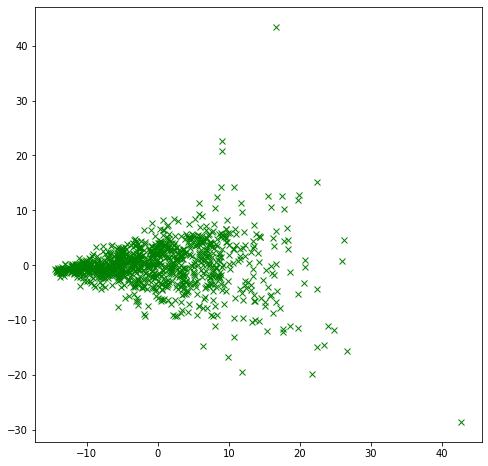

In [15]:
#Plot
plt.figure(figsize=(8, 8))
a = plt.plot(x_2d[:,0],x_2d[:,1],"gx")

## Part 3: Cluster and Plot

Looking at the elbow plot below, there is not one clear point to choose the k value. There appears to be a bend around 3 and then several after 11.

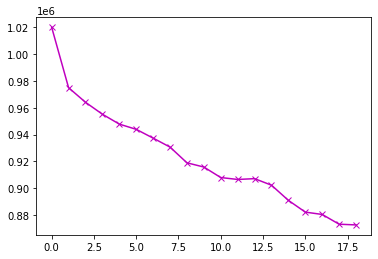

In [16]:
# Elbow Plot
scores=[]
for i in range(1,20):
    #Fit for k
    means=KMeans(n_clusters=i)
    means.fit(x)
    #Get inertia
    scores.append(means.inertia_)
plt.plot(scores,"-mx")

#### Reducing Dimensions before clustering

Since mobilenet gives 1000 features per image, reducing them may improve accuracy by eliminating noise. It is also helpful to show outputs at varying figures of k. 

However, after running the code, it appears that changing the number of dimensions had little to no impact on the output. Many of the posts were very similar in nature and overlapped a bit. Hence, shuffling the groups by reducing dimensions did not make significant difference on recentering. Perhaps if the dataset was larger, there would be more impact.

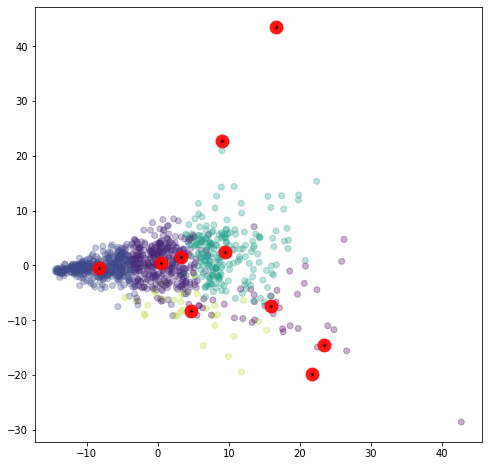

In [17]:
k = 10
num_dimensions = 100 

pca = PCA(n_components=num_dimensions)
x_less_dimensions = pca.fit_transform(x)

#Fit cluster
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x_less_dimensions)

#Plot results
plt.figure(figsize=(8, 8))
plot_clusters(kmeans, x_less_dimensions)

## Part 4: Examine Clusters

Commentary on specific outputs can be found in the pdf. However, in general it seems that analysing based on just one value of k was not useful. Although there were notable groups in each, there were also a lot of inconsistencies. It appears that some types of grouping are better spotted with less clusters, and others with more clusters. Running the code multiple times with different k values and going through them was more beneficial in coming to conclusions for the specific goal of this project.

Certain objects had more difficulty being clustered. This includes animals. In all the clustering attemps, they remained seperated and never appeared together in one group. Another one is meme posts. Although text posts were identified, in general, meme formats were not. Instead, they were seperated and grouped by the contents of them. (eg. if a meme post had a picture of hands, it would be grouped with the all the other hand/nail/rings posts)

In [18]:
#Get image closest to the centre for each cluster
kmeans = KMeans(n_clusters=k, random_state=42)
x_dist = kmeans.fit_transform(x)
representative_indexes = np.argmin(x_dist, axis=0)
representative_ims = my_images[representative_indexes]

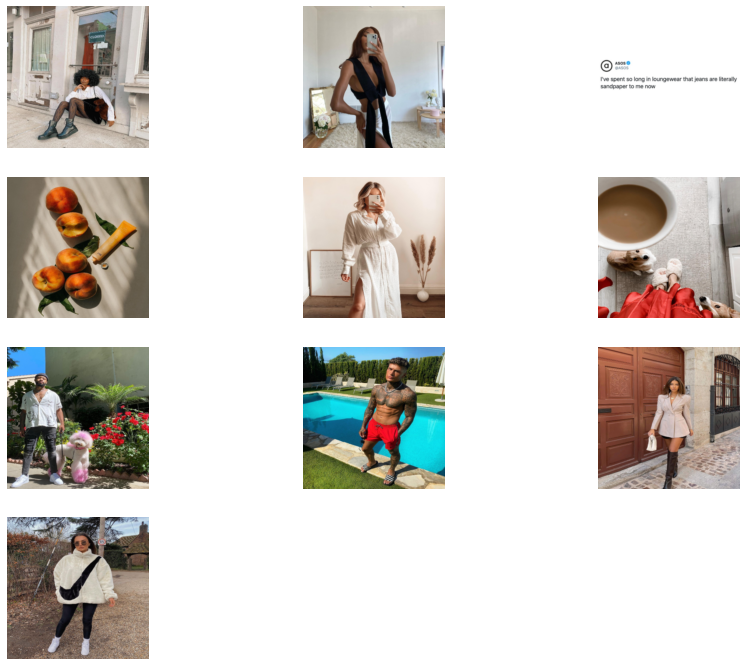

In [19]:
#Draw Them!

plt.figure(figsize=(15,12))
cols = 3
rows = int(np.ceil(k / cols))
for index, im in enumerate(representative_ims):
    loaded_image = cv2.cvtColor(cv2.resize(cv2.imread(im), (480,480)), cv2.COLOR_BGR2RGB)
    plt.subplot(rows, cols, index+1)
    plt.imshow(loaded_image, interpolation="bilinear")
    plt.axis('off')
plt.show()

#### Output by Cluster

In [24]:
cluster = 3
#How many images do you want to see?
num_to_show = 12

#Get images near centre
kmeans = KMeans(n_clusters=k, random_state=42)
x_dist = kmeans.fit_transform(x)
cluster_dist = x_dist[:,cluster]
representative_indexes = cluster_dist.argsort(axis = 0)
representative_ims = my_images[representative_indexes]

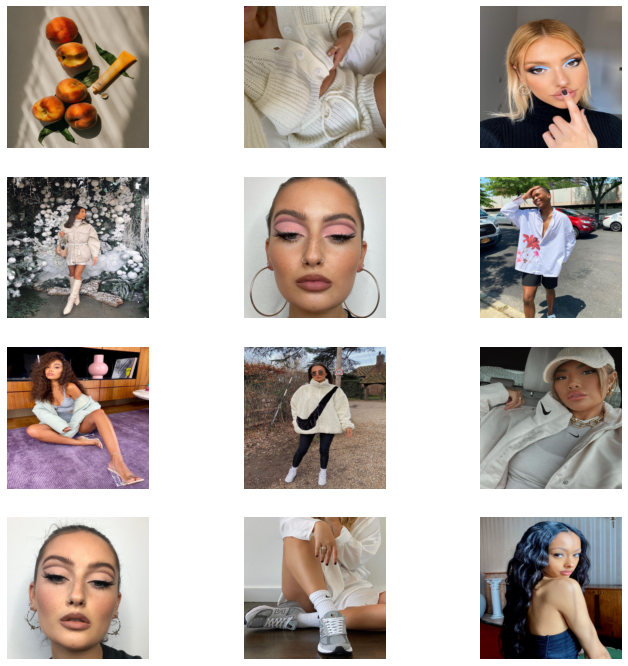

In [25]:
#Draw Them!
plt.figure(figsize=(num_to_show,12))
to_show = representative_ims[:num_to_show]
cols = 3
rows = int(np.ceil(num_to_show / cols))
for index, im in enumerate(to_show):
    loaded_image = cv2.cvtColor(cv2.resize(cv2.imread(im), (480,480)), cv2.COLOR_BGR2RGB)
    plt.subplot(rows, cols, index+1)
    plt.imshow(loaded_image, interpolation="bilinear")
    plt.axis('off')
plt.show()